<a href="https://colab.research.google.com/github/AristiPap/Thesis_Stuff/blob/main/DeepfoolAttack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let’s quickly walkthrough each step of the algorithm:

1) Input is an image x and the classifier f which is the model.

2) The output which is the perturbation

3) We initialize the perturbed image with the original image and the loop variable.

4) We start the iteration and continue for uptil the original label and the perturbed label are not equal.

5 – 8) We consider n classes that had a the most probability after the original class and we store the minimum difference between the original gradients and the gradients of each of these class (w_{k}) and the difference in the labels (f_{k}).

9). The inner loop stores the minimum w_{k} and f_{k}, and using this we calculate the closest hyperplane for the input x

10) We calculate the minimal vector that projects x onto the closest hyperplane that we calculated in 9.

11) We add the minimal perturbation to the image and check if its miclassified.

12–13). Loop variable increased; End Loop

14) Return the total perturbation, which is a sum over all the calculated perturbations.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import math
import copy
import os
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import datetime

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def deepfool(image, net, num_classes=10, overshoot=0.02, max_iter=10):

    f_image = net.forward(image).data.numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.detach().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = torch.tensor(pert_image[None, :],requires_grad=True)
    
    fs = net.forward(x[0])
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.numpy().copy()

        for k in range(1, num_classes):
            
            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = torch.tensor(pert_image, requires_grad=True)
        fs = net.forward(x[0])
        k_i = np.argmax(fs.data.numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, label, k_i, pert_image


In [ ]:
folder = time.strftime('[%d%m%Y]_%H%M%s', time.localtime())
dir_path = _dir_path = "/content/drive/MyDrive/Thesis_notebooks/my_deepfool_attack/images"
os.mkdir(os.path.join(dir_path,folder))

net = models.resnet34(pretrained=True)

# Switch to evaluation mode
net.eval()

im_orig = Image.open('/content/drive/MyDrive/Thesis_notebooks/my_boundary_attack/boundary-attack-master/images/4.jpg')

im = transforms.Compose([
    transforms.ToTensor(),
    ])(im_orig)

img = torch.tensor(im[None,:,:,:],requires_grad =True)
#execute attack
r, loop_i, label_orig, label_pert, pert_image = deepfool(img, net,max_iter=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
print(r, loop_i)

[[[[[-2.2929769e-03 -9.4762642e-04  5.0007977e-04 ... -4.9702660e-04
      3.0037602e-03 -1.2564469e-03]
    [-1.7919235e-03  1.8957023e-04 -2.2905644e-03 ... -8.3240931e-04
     -2.7697149e-03 -2.3215450e-03]
    [ 1.5071634e-03  4.3488466e-03 -2.7887633e-03 ... -2.8384544e-04
     -5.2142208e-03 -4.4551864e-03]
    ...
    [-2.7441864e-03  3.1688155e-04 -5.5831973e-04 ... -1.3204283e-03
     -1.5188195e-03 -6.3480489e-05]
    [ 5.7275384e-04  2.8085394e-04 -9.1075257e-04 ... -1.3749030e-03
     -7.6788530e-04 -2.1443776e-04]
    [ 1.7284636e-03  1.6700318e-03  1.1309085e-03 ... -5.6989997e-04
      4.2435306e-04  3.4473275e-04]]

   [[-3.7154378e-03 -1.7156216e-03  2.8832947e-04 ...  6.8587024e-04
      5.5768280e-03 -6.9618388e-04]
    [-3.1852312e-03 -1.4271510e-03 -3.2596968e-03 ... -1.2177761e-04
      4.4289228e-04  6.1749050e-04]
    [ 4.1900223e-04  3.6617867e-03 -2.7707547e-03 ... -3.2538961e-04
     -9.0658461e-04  5.6772825e-04]
    ...
    [-5.4306365e-03 -1.2047739e-03  7

In [ ]:
folder_id = time.strftime('[%d%m%Y]_%H%M%s', time.localtime())
input_path = "/content/drive/MyDrive/Thesis_notebooks/my_deepfool_attack/images"
os.mkdir(os.path.join(input_path, folder_id))

In [ ]:
from torchvision.utils import save_image
import cv2 

In [ ]:
def _save_image(pert_image, label, folder,orig = False):
    """Export image file."""
    # Reverse preprocessing, see https://github.com/keras-team/keras/blob/master/keras/applications/imagenet_utils.py
    # Convert array to image and save
   # arr_ = np.squeeze(pert_image) # you can give axis attribute if you wanna squeeze in specific dimension
    id_no = time.strftime('%Y%m%d_%H%M%S', datetime.datetime.now().timetuple())
    
    if orig:
      pert_image = pert_image.save(os.path.join("/content/drive/MyDrive/Thesis_notebooks/my_deepfool_attack/images", folder,"{}_{}.png".format(id_no, label)))
      # pert_image_numpy = np.array(pert_image)
      # result=cv2.imwrite(os.path.join("/content/drive/MyDrive/Thesis_notebooks/my_deepfool_attack/images", folder,"{}_{}.png".format(id_no, label)), pert_image_numpy)
      # if result==True:
      #   print("File saved successfully")
      # else:
      #   print("Error in saving file")
     # plt.savefig(os.path.join("/content/drive/MyDrive/Thesis_notebooks/my_deepfool_attack/images", folder,"{}_{}.png".format(id_no, label)), dpi=300, bbox_inches='tight')
    else:
      pert_image_numpy = pert_image.detach().squeeze().numpy()
      print(pert_image_numpy.shape)
      plt.figure()
      tmp_img = pert_image_numpy
      plt.imshow(pert_image_numpy.transpose(1,2,0))
  
      norm = plt.Normalize(vmin=tmp_img.transpose(1,2,0).min(), vmax=tmp_img.transpose(1,2,0).max())
      # map the normalized data to colors
      # image is now RGBA (512x512x4) 
      _image =  (1/(2*1.050000000745058)) * tmp_img + 0.35
      # Save with predicted label for image (may not be adversarial due to uint8 conversion)
      plt.imsave(os.path.join("/content/drive/MyDrive/Thesis_notebooks/my_deepfool_attack/images", folder,"{}_{}.png".format(id_no, label)), _image.transpose(1,2,0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review yo

Original label =  n03095699 container ship
Perturbed label =  n04149813 scoreboard
(3, 28, 28)


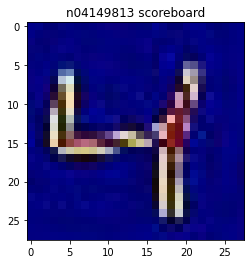

In [ ]:
labels = open(os.path.join('/content/drive/MyDrive/Thesis_notebooks/my_deepfool_attack/synset_words.txt'), 'r').read().split('\n')

str_label_orig = labels[np.int(label_orig)].split(',')[0]
str_label_pert = labels[np.int(label_pert)].split(',')[0]

print("Original label = ", str_label_orig)
print("Perturbed label = ", str_label_pert)

pert_image_numpy = pert_image.detach().squeeze().numpy()
print(pert_image_numpy.shape)
plt.figure()
plt.imshow(pert_image_numpy.transpose(1,2,0))
plt.title(str_label_pert)
plt.show()

(3, 28, 28)


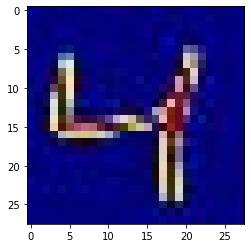

In [ ]:
_save_image(im_orig, str_label_orig, folder_id, orig = True)
_save_image(pert_image, str_label_pert, folder_id)

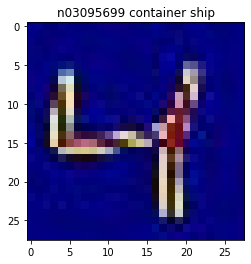

In [ ]:
plt.figure()
plt.imshow(im_orig)
plt.title(str_label_orig)
plt.show()